In [ ]:
# Install dependencies (run once)
%pip install --quiet pythonnet numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# import sys
# import time
# from pathlib import Path

# import numpy as np
# import matplotlib.pyplot as plt

# import clr

# # Update this if your Kinect SDK is installed elsewhere
# default_sdk_path = Path(r"C:\Program Files\Microsoft SDKs\Kinect\v2.0_1409\Assemblies")
# if default_sdk_path.exists() and str(default_sdk_path) not in sys.path:
#     sys.path.append(str(default_sdk_path))

# clr.AddReference("System")
# clr.AddReference("Microsoft.Kinect")

# import System
# from Microsoft.Kinect import KinectSensor, ColorImageFormat

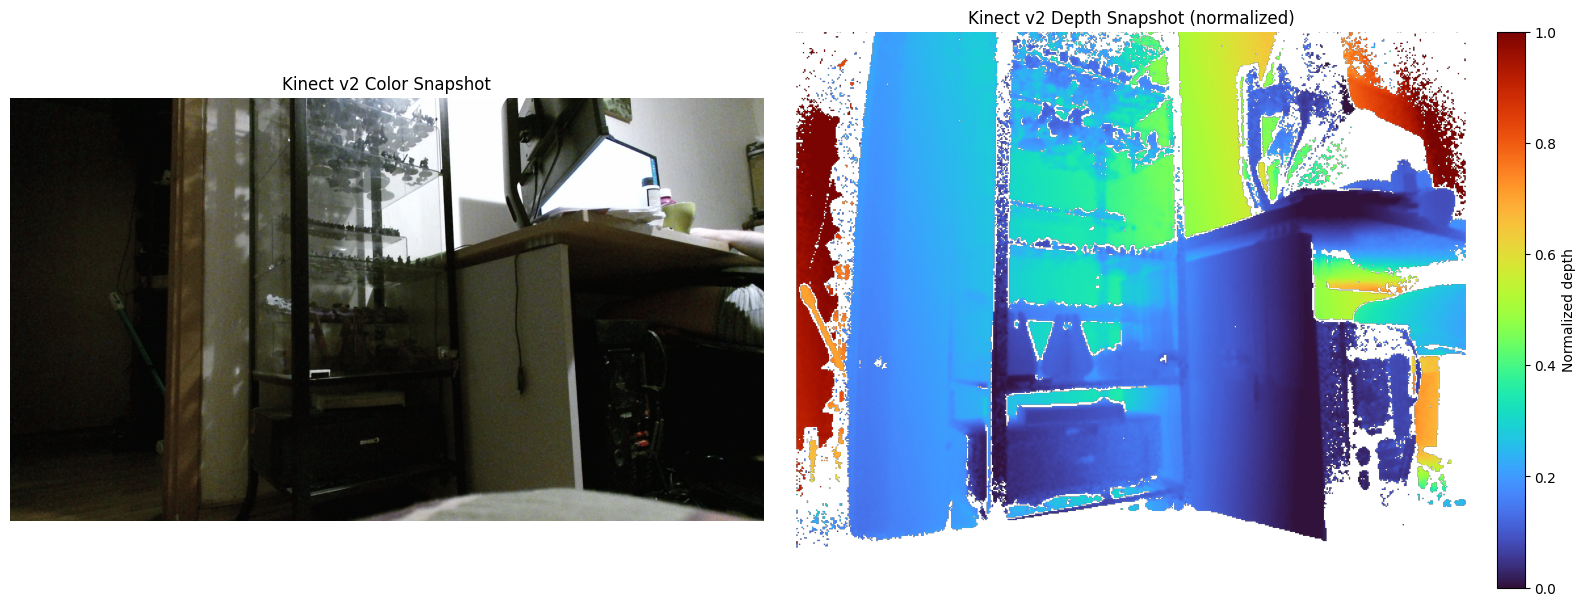

In [ ]:
import sys
import time
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import clr

# Update this if your Kinect SDK is installed elsewhere
default_sdk_path = Path(r"C:\Program Files\Microsoft SDKs\Kinect\v2.0_1409\Assemblies")
if default_sdk_path.exists() and str(default_sdk_path) not in sys.path:
    sys.path.append(str(default_sdk_path))

clr.AddReference("System")
clr.AddReference("Microsoft.Kinect")

import System
from Microsoft.Kinect import KinectSensor, ColorImageFormat
import ctypes


sdk_path = Path(r"C:\Program Files\Microsoft SDKs\Kinect\v2.0_1409\Assemblies")
if sdk_path.exists() and str(sdk_path) not in sys.path:
    sys.path.append(str(sdk_path))

clr.AddReference("System")
clr.AddReference("Microsoft.Kinect")


def dispose(obj):
    if obj is None:
        return
    for method_name in ("Dispose", "Close"):
        method = getattr(obj, method_name, None)
        if callable(method):
            method()
            break


sensor = KinectSensor.GetDefault()
if sensor is None:
    raise RuntimeError("No Kinect sensor detected. Check USB/power and try again.")

sensor.Open()
start = time.time()
while not sensor.IsAvailable and time.time() - start < 5.0:
    time.sleep(0.1)

color_reader = sensor.ColorFrameSource.OpenReader()
depth_reader = sensor.DepthFrameSource.OpenReader()
if color_reader is None or depth_reader is None:
    dispose(color_reader)
    dispose(depth_reader)
    sensor.Close()
    raise RuntimeError("Failed to open Kinect color/depth readers.")

color_frame = None
depth_frame = None

# Give the depth camera a little longer to initialize
initial_wait = 1.5
if initial_wait > 0:
    time.sleep(initial_wait)

deadline = time.time() + 12.0
while time.time() < deadline:
    if color_frame is None:
        latest_color = color_reader.AcquireLatestFrame()
        if latest_color is not None:
            color_frame = latest_color
    if depth_frame is None:
        latest_depth = depth_reader.AcquireLatestFrame()
        if latest_depth is not None:
            depth_frame = latest_depth
    if color_frame is not None and depth_frame is not None:
        break
    time.sleep(0.05)

if color_frame is None or depth_frame is None:
    dispose(color_frame)
    dispose(depth_frame)
    color_reader.Dispose()
    depth_reader.Dispose()
    sensor.Close()
    raise TimeoutError(
        "Timed out waiting for both color and depth frames from the Kinect sensor."
    )

color_desc = color_frame.FrameDescription
color_width, color_height = color_desc.Width, color_desc.Height
color_buffer = System.Array.CreateInstance(System.Byte, color_width * color_height * 4)
color_frame.CopyConvertedFrameDataToArray(color_buffer, ColorImageFormat.Bgra)
color_np = np.frombuffer(bytearray(color_buffer), dtype=np.uint8).reshape(
    (color_height, color_width, 4)
)
color_rgb = color_np[:, :, [2, 1, 0]]

depth_desc = depth_frame.FrameDescription
depth_width, depth_height = depth_desc.Width, depth_desc.Height
locked_depth = depth_frame.LockImageBuffer()
try:
    depth_ptr = locked_depth.UnderlyingBuffer.ToInt64()
    if depth_ptr == 0:
        raise RuntimeError("Depth buffer pointer is null.")
    depth_size = locked_depth.Size
    depth_pointer = ctypes.cast(
        ctypes.c_void_p(depth_ptr), ctypes.POINTER(ctypes.c_uint16)
    )
    depth_data = (
        np.ctypeslib.as_array(depth_pointer, shape=(depth_size // 2,))
        .copy()
        .reshape((depth_height, depth_width))
    )
finally:
    locked_depth.Dispose()

dispose(color_frame)
dispose(depth_frame)
color_reader.Dispose()
depth_reader.Dispose()
sensor.Close()

depth_mm = depth_data.astype(np.float32)
depth_mm[depth_mm == 0] = np.nan

valid_depth = depth_mm[np.isfinite(depth_mm)]
if valid_depth.size == 0:
    raise RuntimeError("Depth frame contains no valid pixels.")

depth_min, depth_max = np.percentile(valid_depth, [2, 98])
normalized_depth = np.clip((depth_mm - depth_min) / (depth_max - depth_min), 0, 1)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow(color_rgb)
axes[0].set_title("Kinect v2 Color Snapshot")
axes[0].axis("off")

im = axes[1].imshow(normalized_depth, cmap="turbo", origin="upper")
axes[1].set_title("Kinect v2 Depth Snapshot (normalized)")
axes[1].axis("off")
fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04, label="Normalized depth")

plt.tight_layout()
plt.show()